In [1]:
annot_dir = '../Unity_dataset/Dataset/annotation_definitions.json'

In [2]:
import os
import glob
import json
import pandas as pd

In [3]:
f = open(annot_dir)
data = json.load(f)

In [4]:
new_dict = {}
df = pd.DataFrame(columns=['label','r','g','b'])
df

Empty DataFrame
Columns: [label, r, g, b]
Index: []

In [5]:
for i in data[list(data.keys())[1]][1]['spec']:
    new_dict['label'] = i['label_name']
    new_dict['r'] = [int(i['pixel_value']['r']*255)]
    new_dict['g'] = [int(i['pixel_value']['g']*255)]
    new_dict['b'] = [int(i['pixel_value']['b']*255)]
    df = pd.concat([df,pd.DataFrame(new_dict)])

In [6]:
df = df.reset_index()[df.reset_index().columns[1:]]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   35 non-null     object
 1   r       35 non-null     object
 2   g       35 non-null     object
 3   b       35 non-null     object
dtypes: object(4)
memory usage: 1.2+ KB


In [7]:
df

label   r   g   b
0              unlabeled   0   0   0
1            ego vehicle   1   1   1
2   rectification border   2   2   2
3             out of roi   3   3   3
4                 static   4   4   4
5                dynamic   5   5   5
6                 ground   6   6   6
7                   road   7   7   7
8               sidewalk   8   8   8
9                parking   9   9   9
10            rail track  10  10  10
11              building  11  11  11
12                  wall  12  12  12
13                 fence  13  13  13
14            guard rail  14  14  14
15                bridge  15  15  15
16                tunnel  16  16  16
17                  pole  17  17  17
18             polegroup  18  18  18
19         traffic light  19  19  19
20          traffic sign  20  20  20
21            vegetation  21  21  21
22               terrain  22  22  22
23                   sky  23  23  23
24                person  24  24  24
25                 rider  25  25  25
26                   car  26  26  26
27                 truck  27  27  27
28                   bus  28  28  28
29               caravan  29  29  29
30               trailer  30  30  30
31                 train  31  31  31
32            motorcycle  32  32  32
33               bicycle  33  33  33
34         license plate  -1  -1  -1

In [8]:
from data_processing.Augmentation import *
from data_processing.helper import *

In [9]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import re

In [10]:
import time

In [11]:
DATA_DIR = './SolvedDataset/'

In [12]:
x_train_dir = os.path.join(DATA_DIR, 'Train/RGB')
y_train_dir = os.path.join(DATA_DIR, 'Train/SemanticSegmentation')

x_valid_dir = os.path.join(DATA_DIR, 'Valid/RGB')
y_valid_dir = os.path.join(DATA_DIR, 'Valid/SemanticSegmentation')

x_test_dir = os.path.join(DATA_DIR, 'Test/RGB')
y_test_dir = os.path.join(DATA_DIR, 'Test/SemanticSegmentation')

In [13]:
labels = df['label'].to_list()

In [14]:
index_label = [0, 7, 11, 20, 22, 26]
index_label

[0, 7, 11, 20, 22, 26]

In [15]:
classes = df.label[index_label].to_list()
classes

['unlabeled', 'road', 'building', 'traffic sign', 'terrain', 'car']

In [16]:
dataset = Dataset(x_train_dir, y_train_dir, 
                  classes = classes,labels=labels)

image, mask = dataset[5] # get some sample

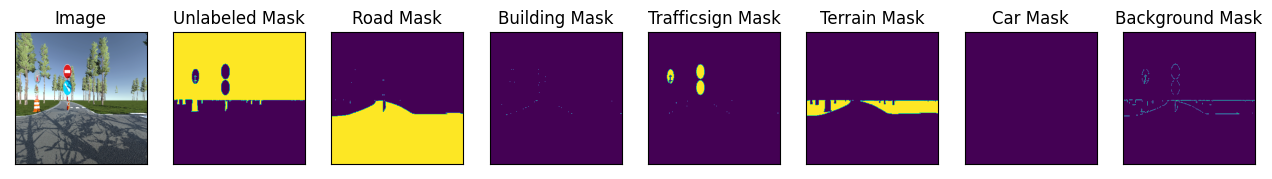

In [17]:
visualize(
    image=image, 
    unlabeled_mask=mask[..., 0].squeeze(),
    road_mask=mask[..., 1].squeeze(),
    building_mask=mask[..., 2].squeeze(),
    trafficsign_mask=mask[..., 3].squeeze(),
    terrain_mask=mask[..., 4].squeeze(),
    car_mask=mask[..., 5].squeeze(),
    background_mask=mask[..., 6].squeeze()
)

In [18]:
dataset = Dataset(x_train_dir, y_train_dir, 
                  classes = classes, 
                  augmentation=get_training_augmentation(),labels=labels)

/home/waflol/anaconda3/envs/myenv/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1800: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/waflol/anaconda3/envs/myenv/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1826: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [19]:
image, mask = dataset[20] # get some sample

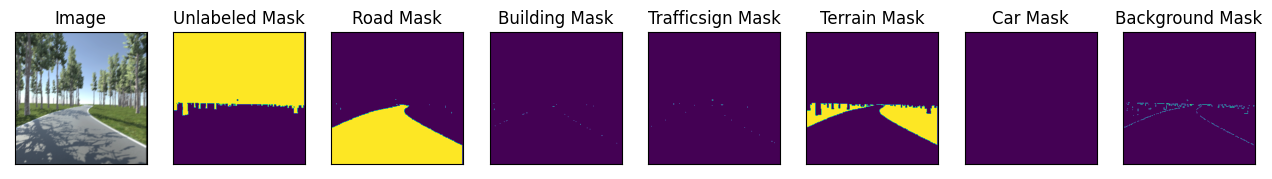

In [20]:
visualize(
    image=image, 
    unlabeled_mask=mask[..., 0].squeeze(),
    road_mask=mask[..., 1].squeeze(),
    building_mask=mask[..., 2].squeeze(),
    trafficsign_mask=mask[..., 3].squeeze(),
    terrain_mask=mask[..., 4].squeeze(),
    car_mask=mask[..., 5].squeeze(),
    background_mask=mask[..., 6].squeeze()
)

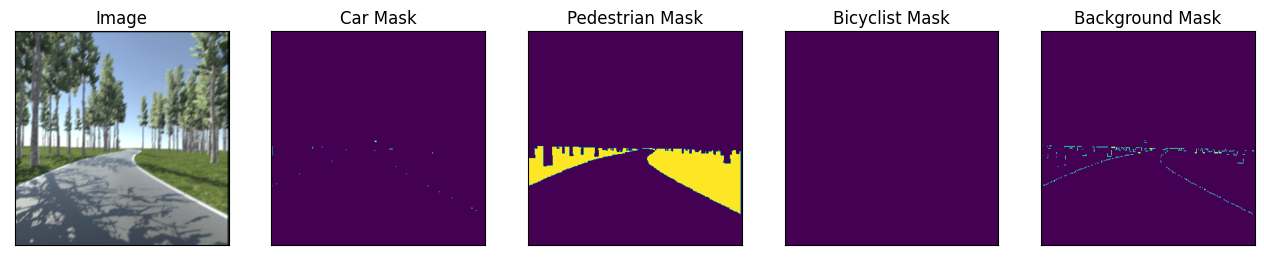

In [21]:
visualize(
    image=image, 
    car_mask=mask[..., 3].squeeze(),
    pedestrian_mask=mask[..., 4].squeeze(),
    bicyclist_mask=mask[..., 5].squeeze(),
    background_mask=mask[..., 6].squeeze(),
)

In [22]:
import segmentation_models as sm
sm.set_framework('tf.keras')

Segmentation Models: using `keras` framework.


In [23]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 4
CLASSES = classes
LR = 0.0001

# Set number of epochs
EPOCHS = 250

# Patience for the learning rate
LR_PATIENCE = 5

# Patience for early stopping
STOPPING_PATIENCE = 30

preprocess_input = sm.get_preprocessing(BACKBONE)

In [24]:
CLASSES

['unlabeled', 'road', 'building', 'traffic sign', 'terrain', 'car']

In [25]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.FPN(BACKBONE, classes=n_classes, activation=activation)

2021-12-17 10:37:50.389982: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-17 10:37:50.429255: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-17 10:37:50.430518: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-17 10:37:50.433650: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [26]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([1, 2, 3,4,5,6,0.5])) 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, loss = total_loss, metrics = metrics)

In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 stem_conv (Conv2D)             (None, None, None,   1080        ['input_1[0][0]']                
                                40)                                                               
                                                                                                  
 stem_bn (BatchNormalization)   (None, None, None,   160         ['stem_conv[0][0]']              
                                40)                                                           

In [29]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [28]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
    labels=labels
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
    labels=labels
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 320, 320, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 320, 320, n_classes)

In [31]:
from tensorflow.keras.callbacks import EarlyStopping
# define callbacks for learning rate scheduling and best checkpoints saving
checkpoint = tf.keras.callbacks.ModelCheckpoint('./checkpoint/Unity_efficientnetb3_FPN.h5', monitor='val_loss',save_weights_only=True, save_best_only=True, mode='min')
learning_rate = tf.keras.callbacks.ReduceLROnPlateau(patience=LR_PATIENCE, verbose=1, factor=0.5, min_delta=0.00001)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=STOPPING_PATIENCE, verbose=1, restore_best_weights=True)


In [32]:
# train model
pre_train = time.time()
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=[learning_rate,early_stopping,checkpoint], 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)
time_training = time.time() - pre_train

/tmp/ipykernel_29919/1794659408.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/250


2021-12-12 22:08:26.748007: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8204
2021-12-12 22:08:29.952679: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.22GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-12-12 22:08:30.169352: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.87GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-12-12 22:08:30.414175: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.87GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory

282/282 [==============================] - ETA: 0s - loss: 0.5273 - iou_score: 0.4687 - f1-score: 0.5093

2021-12-12 22:11:04.268280: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.98GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-12-12 22:11:04.364862: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.35GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


282/282 [==============================] - 215s 695ms/step - loss: 0.5273 - iou_score: 0.4687 - f1-score: 0.5093 - val_loss: 0.4994 - val_iou_score: 0.5673 - val_f1-score: 0.6036 - lr: 1.0000e-04
Epoch 2/250
282/282 [==============================] - 181s 642ms/step - loss: 0.4701 - iou_score: 0.5195 - f1-score: 0.5622 - val_loss: 0.4832 - val_iou_score: 0.5822 - val_f1-score: 0.6193 - lr: 1.0000e-04
Epoch 3/250
282/282 [==============================] - 182s 644ms/step - loss: 0.4605 - iou_score: 0.5326 - f1-score: 0.5754 - val_loss: 0.4656 - val_iou_score: 0.5981 - val_f1-score: 0.6358 - lr: 1.0000e-04
Epoch 4/250
282/282 [==============================] - 183s 648ms/step - loss: 0.4549 - iou_score: 0.5381 - f1-score: 0.5804 - val_loss: 0.4621 - val_iou_score: 0.6060 - val_f1-score: 0.6438 - lr: 1.0000e-04
Epoch 5/250
282/282 [==============================] - 183s 648ms/step - loss: 0.4547 - iou_score: 0.5448 - f1-score: 0.5910 - val_loss: 0.4557 - val_iou_score: 0.5812 - val_f1-sco

Epoch 76/250
282/282 [==============================] - 183s 647ms/step - loss: 0.2898 - iou_score: 0.6515 - f1-score: 0.7354 - val_loss: 0.2972 - val_iou_score: 0.6641 - val_f1-score: 0.7108 - lr: 6.2500e-06
Epoch 77/250
282/282 [==============================] - 182s 644ms/step - loss: 0.2919 - iou_score: 0.6483 - f1-score: 0.7332 - val_loss: 0.2977 - val_iou_score: 0.6640 - val_f1-score: 0.7107 - lr: 6.2500e-06
Epoch 78/250
282/282 [==============================] - 182s 645ms/step - loss: 0.2877 - iou_score: 0.6543 - f1-score: 0.7370 - val_loss: 0.2976 - val_iou_score: 0.6634 - val_f1-score: 0.7100 - lr: 6.2500e-06
Epoch 79/250
282/282 [==============================] - 182s 645ms/step - loss: 0.2899 - iou_score: 0.6507 - f1-score: 0.7343 - val_loss: 0.2976 - val_iou_score: 0.6636 - val_f1-score: 0.7103 - lr: 6.2500e-06
Epoch 80/250
282/282 [==============================] - 182s 644ms/step - loss: 0.2855 - iou_score: 0.6554 - f1-score: 0.7388 - val_loss: 0.2975 - val_iou_score: 0.

Epoch 111/250
282/282 [==============================] - 182s 645ms/step - loss: 0.2920 - iou_score: 0.6493 - f1-score: 0.7337 - val_loss: 0.2970 - val_iou_score: 0.6642 - val_f1-score: 0.7108 - lr: 1.9531e-07
Epoch 112/250
282/282 [==============================] - 183s 648ms/step - loss: 0.2899 - iou_score: 0.6515 - f1-score: 0.7353 - val_loss: 0.2968 - val_iou_score: 0.6644 - val_f1-score: 0.7110 - lr: 1.9531e-07
Epoch 113/250
282/282 [==============================] - 182s 644ms/step - loss: 0.2890 - iou_score: 0.6521 - f1-score: 0.7361 - val_loss: 0.2971 - val_iou_score: 0.6642 - val_f1-score: 0.7107 - lr: 1.9531e-07
Epoch 114/250
282/282 [==============================] - 182s 645ms/step - loss: 0.2866 - iou_score: 0.6534 - f1-score: 0.7375 - val_loss: 0.2970 - val_iou_score: 0.6642 - val_f1-score: 0.7107 - lr: 1.9531e-07
Epoch 115/250
282/282 [==============================] - 182s 644ms/step - loss: 0.2842 - iou_score: 0.6592 - f1-score: 0.7425 - val_loss: 0.2971 - val_iou_scor

In [33]:
print('Time training:{} (s)'.format(time_training))

Time training:28408.639620542526 (s)


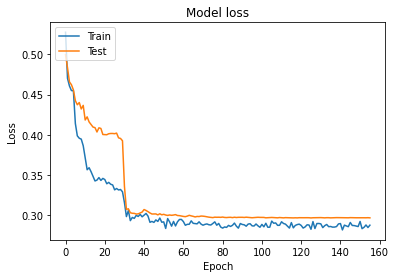

In [34]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

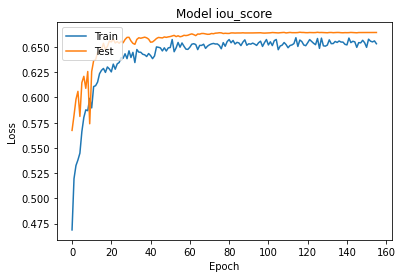

In [35]:
# Plot training & validation loss values
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [29]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    preprocessing=get_preprocessing(preprocess_input),
    labels=labels
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [30]:
# load best weights
model.load_weights('./checkpoint/Unity_efficientnetb3_FPN.h5')

In [31]:
scores  = model.evaluate_generator(test_dataloader)
print("Loss:{:.5}".format(scores[0]))
for metric,value in zip(metrics,scores[1:]):
    print("mean {}:{:.5}".format(metric.__name__,value))

/tmp/ipykernel_6301/2477453485.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores  = model.evaluate_generator(test_dataloader)
2021-12-17 10:38:15.318342: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8204


Loss:0.29254
mean iou_score:0.66962
mean f1-score:0.71426


In [32]:
classes
visualize(
    image=image, 
    unlabeled_mask=mask[..., 0].squeeze(),
    road_mask=mask[..., 1].squeeze(),
    building_mask=mask[..., 2].squeeze(),
    trafficsign_mask=mask[..., 3].squeeze(),
    terrain_mask=mask[..., 4].squeeze(),
    car_mask=mask[..., 5].squeeze(),
    background_mask=mask[..., 6].squeeze()
)

['unlabeled', 'road', 'building', 'traffic sign', 'terrain', 'car']

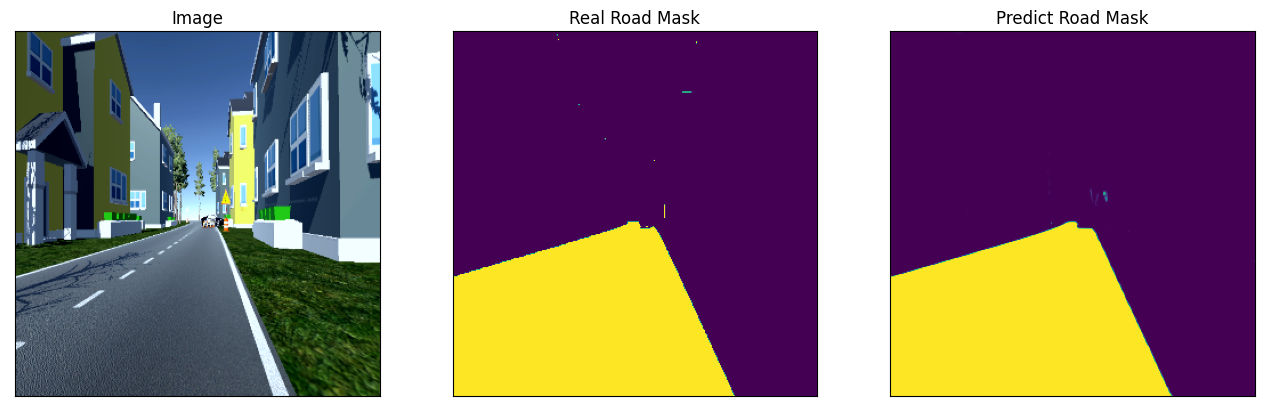

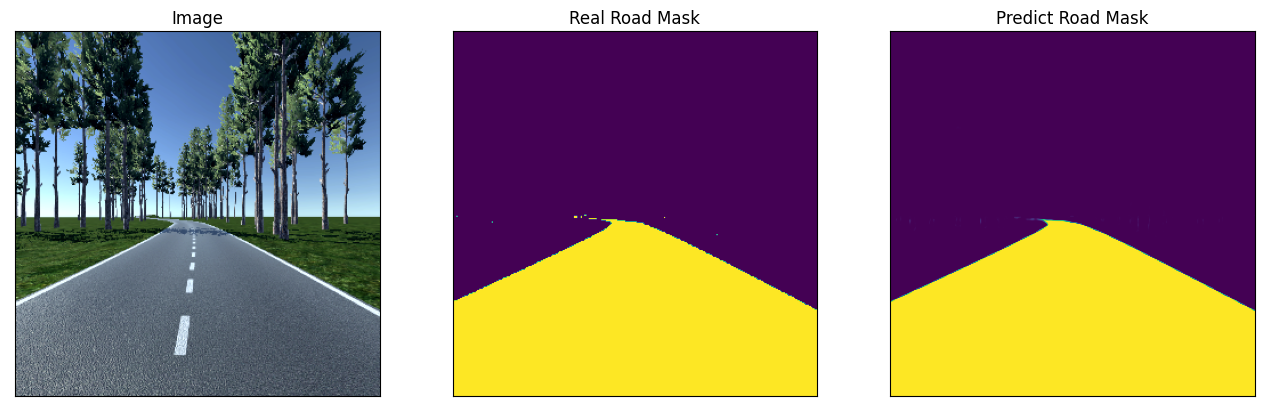

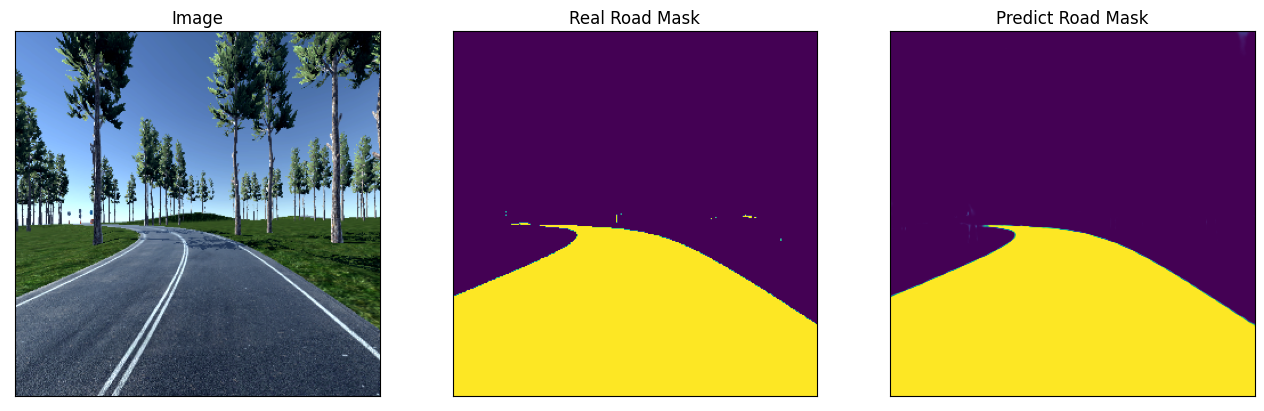

In [47]:
n = 3
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    
    visualize(
        image=denormalize(image.squeeze()),
        real_road_mask=gt_mask[...,1].squeeze(),
        predict_road_mask=pr_mask[...,1].squeeze(),
    )

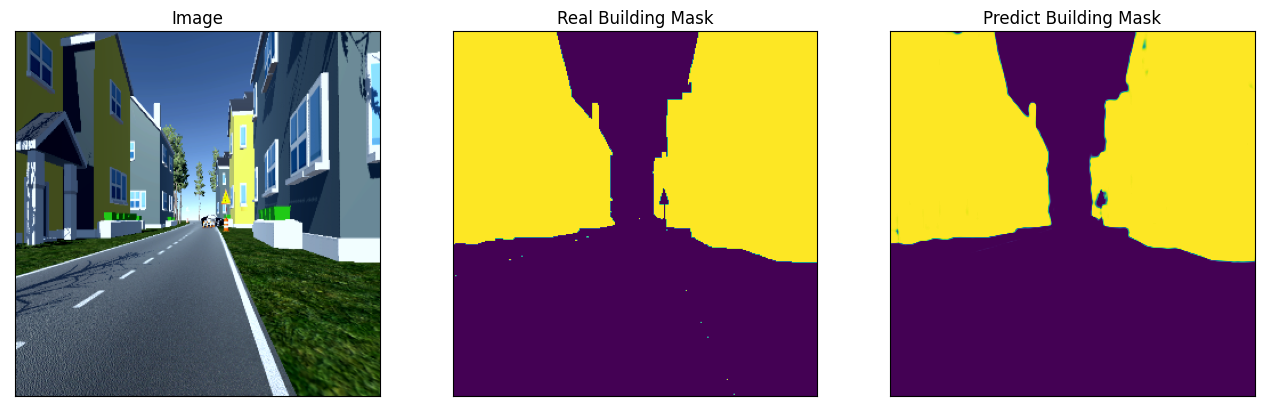

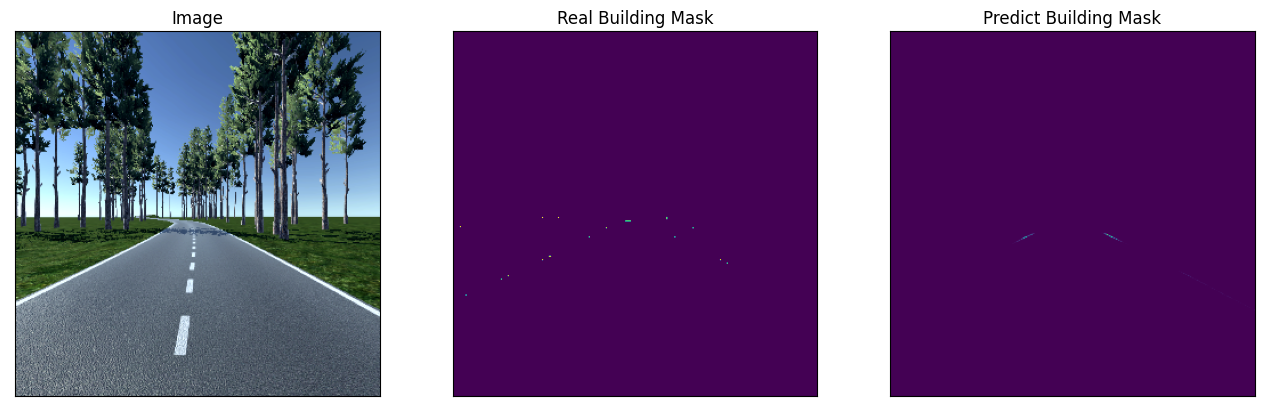

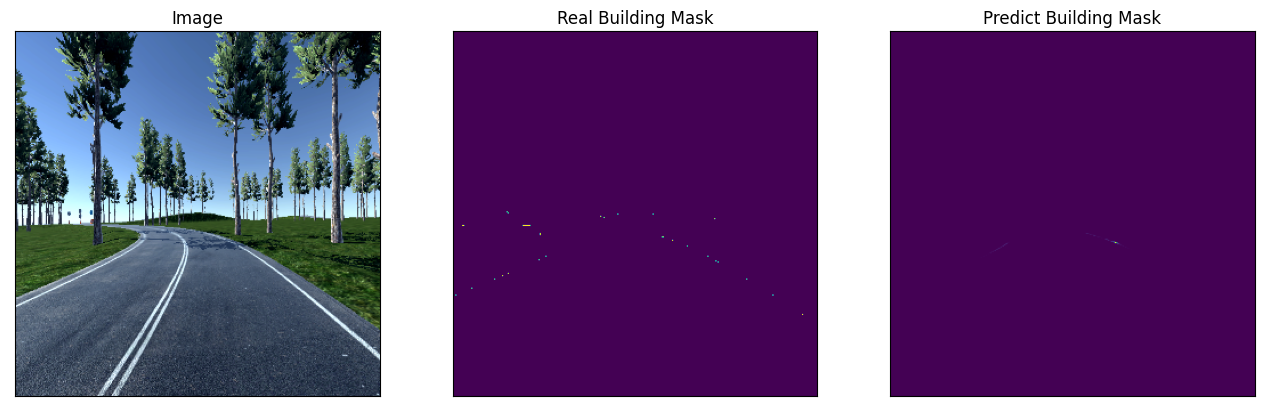

In [48]:
for i in ids:
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    
    visualize(
        image=denormalize(image.squeeze()),
        real_building_mask=gt_mask[...,2].squeeze(),
        predict_building_mask=pr_mask[...,2].squeeze(),
    )

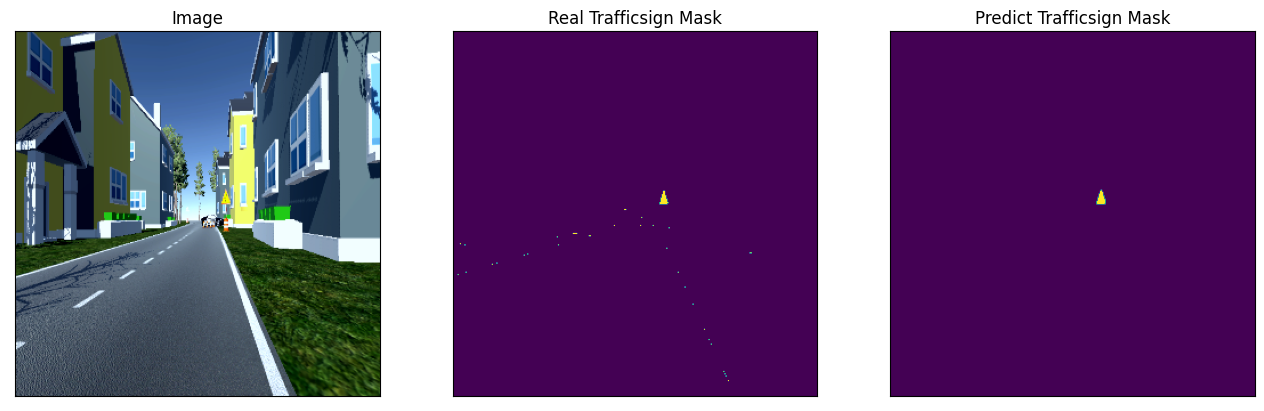

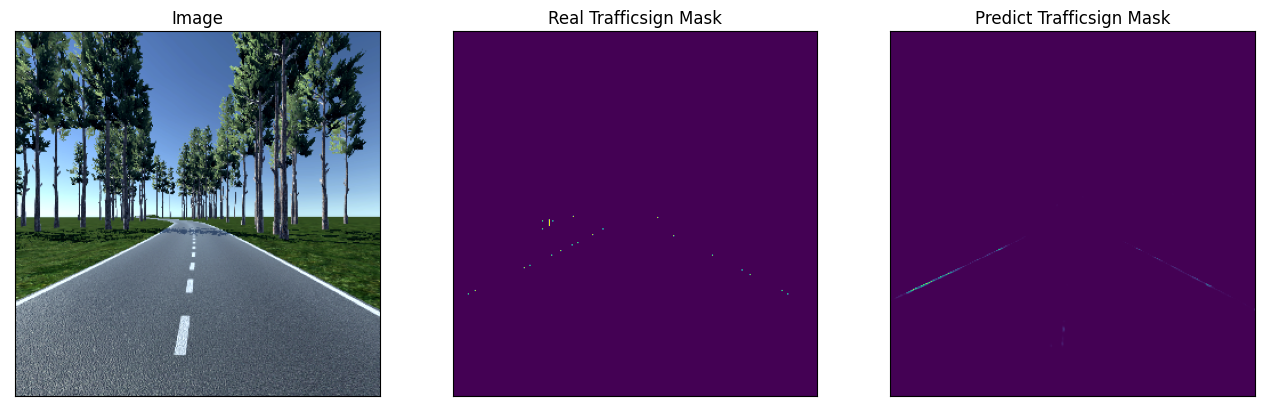

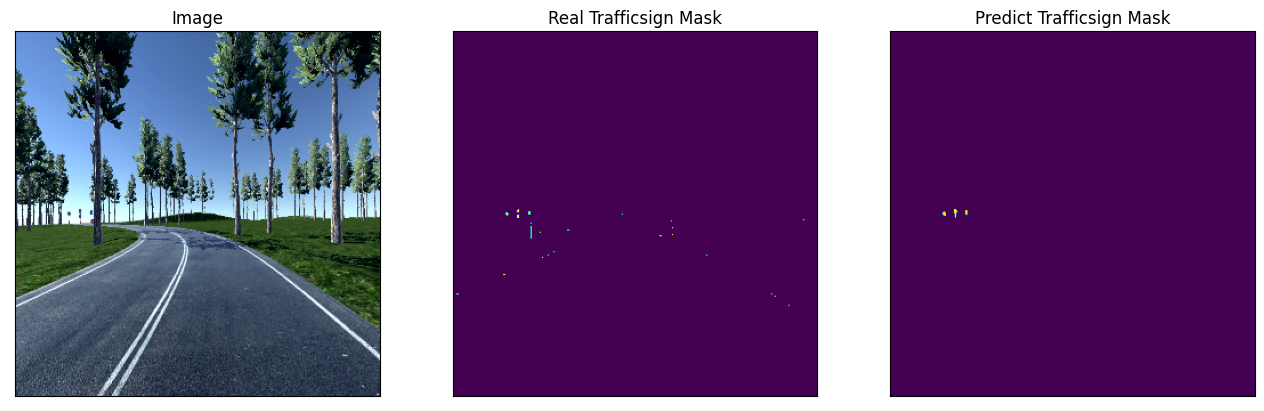

In [49]:
for i in ids:
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    
    visualize(
        image=denormalize(image.squeeze()),
        real_trafficSign_mask=gt_mask[...,3].squeeze(),
        predict_trafficSign_mask=pr_mask[...,3].squeeze(),
    )

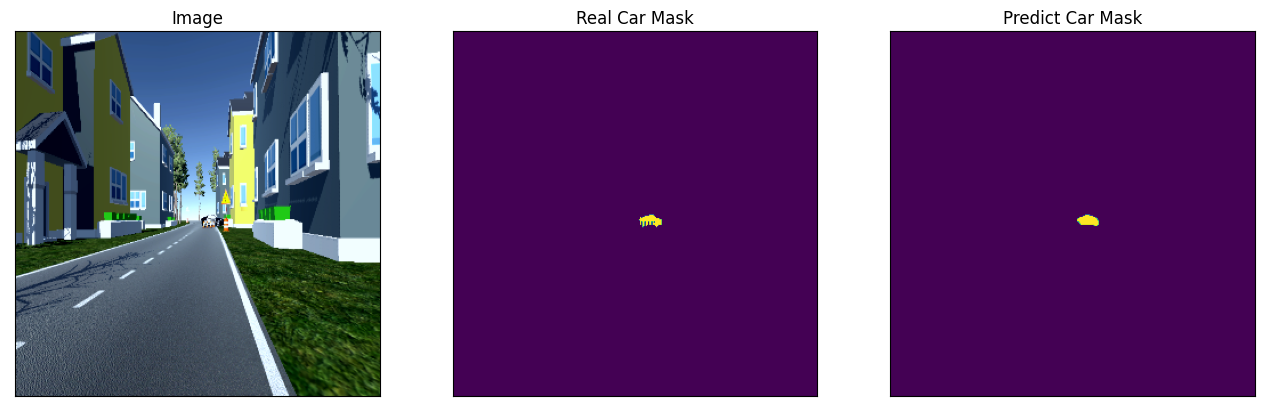

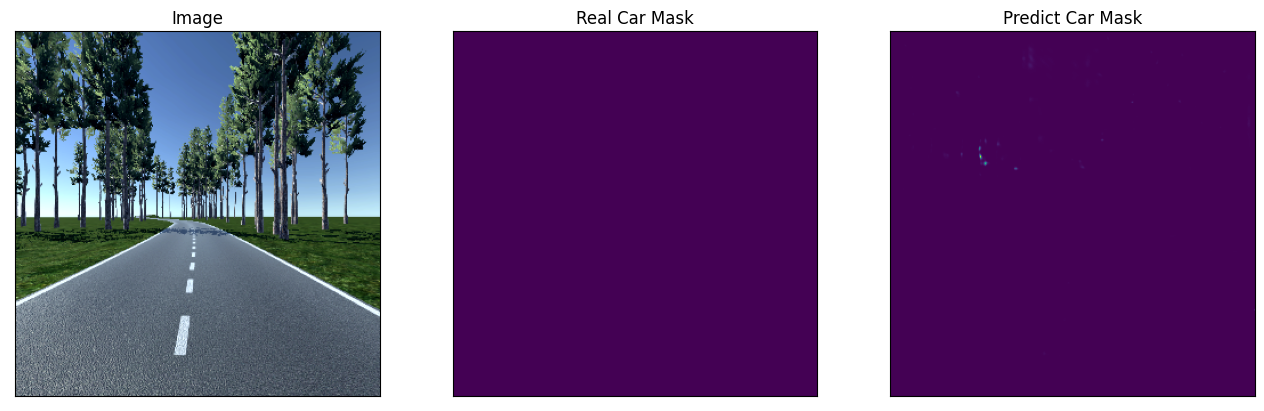

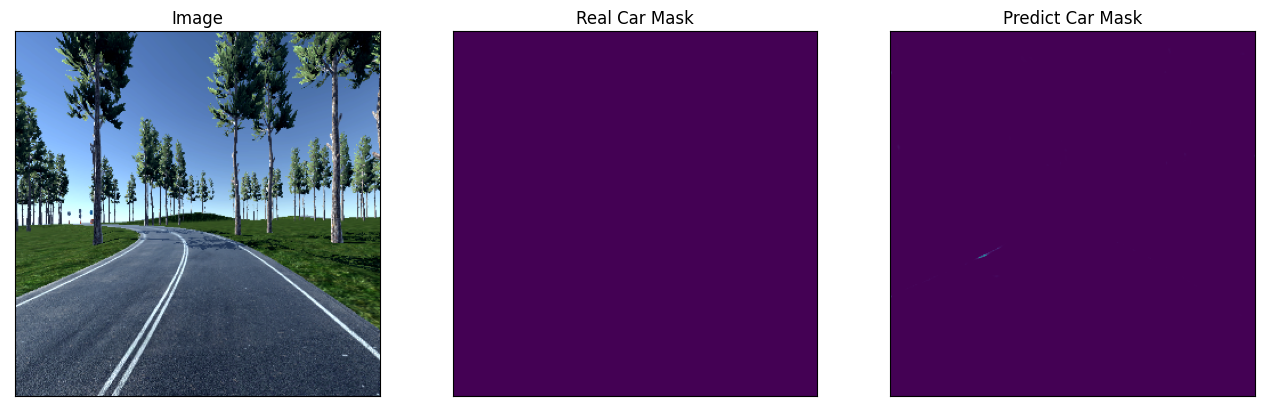

In [50]:
for i in ids:
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    
    visualize(
        image=denormalize(image.squeeze()),
        real_car_mask=gt_mask[...,5].squeeze(),
        predict_car_mask=pr_mask[...,5].squeeze(),
    )